In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

plt.rcParams['font.size'] = 14

A/D conversion
=============

In [2]:
##CD = waves.CDFormatSampler('CD')

##SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
##DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
##BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic PCM samplers
# Define sampling frequency (Hz) and resolution (bits) to your heart's content
ADC_list = []
for sampler, freq, bits in [
    #('PCM 1', 44100, 4),   # Same CD frequency, lower resolution
    ##('PCM 2', 14000, 16),  # Same CD resolution, lower frequency
    ('CD', 44100, 16),  # Same CD resolution, lower frequency
    #('LOW', 14000, 4),  # Same CD resolution, lower frequency
]:
    ADC_list.append(waves.PCMSampler(sampler, freq, bits))

In [3]:
dither_setup = {
    'nodither': {
        'state': False,
        'label': 'Without dither',
        'c': 'C1',
        'w': 3,
    },
    'dither': {
        'state': True,
        'label': 'With dither',
        'c': 'C0',
        'w': 1,
    },
}
dither_setup.pop('dither')

{'state': True, 'label': 'With dither', 'c': 'C0', 'w': 1}

In [4]:
experiments = [
    (waves.AnalogSineWave, '1 kHz', 1e3, 2.8),
    (waves.AnalogSineWave, '6 kHz', 6e3, 7),
    (waves.AnalogSineWave, '14 kHz', 14e3, 20),
    (waves.AnalogSineWave, '14.7 kHz', 14.7e3, 12.5),
    (waves.AnalogSineWave, '18 kHz', 18e3, 20),
    (waves.AnalogSineWave, '20 kHz', 20e3, 30),
    (waves.AnalogSineWave, '21 kHz', 21e3, 30),
    (waves.AnalogSineWave, '22 kHz', 22e3, 30),
    (waves.AnalogSineWave, '22 kHz', 22e3, 300),
    (waves.AnalogSineWave, '22.05 kHz', 22.05e3, 30),
    (waves.AnalogSineWave, '30 kHz', 30e3, 30),
]
exp_results = []

Let us see how the noise behaves without and with dither added:

CD's stream without dither (65536 levels): [32767 36644 40443 44086 47500 50615 53369 55705 57576 58945 ... 18862 15666 12816 10371 8380 6883 5910 5482 5606 6281]
CD's stream without dither (65536 levels): [32767 53369 59810 47664 25278 8040 7798 24718 47171 59723 ... 6145 10710 30436 51763 60034 49563 27547 9119 6945 22520]
CD's stream without dither (65536 levels): [32767 57657 12293 24718 59861 18529 17385 59658 26029 11418 ... 8468 54116 39505 5876 48149 47005 5673 40816 53241 7877]
CD's stream without dither (65536 levels): [32767 56415 9119 32767 56415 9119 32767 56415 9119 32767 ... 56415 9119 32767 56415 9119 32767 56415 9119 32767 56415]
CD's stream without dither (65536 levels): [32767 47664 7798 59723 12553 39693 41371 11418 59947 8557 ... 19367 56977 5587 54116 24163 25841 52981 5811 57736 17870]
CD's stream without dither (65536 levels): [32767 40630 17708 53747 7643 59907 5910 57066 13084 46167 ... 10710 58525 5490 59253 9316 51197 20919 37029 36452 21448]
CD's stream wit

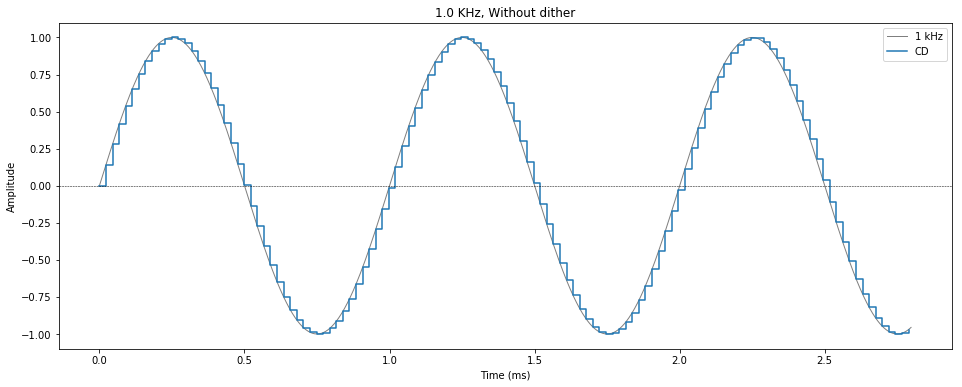

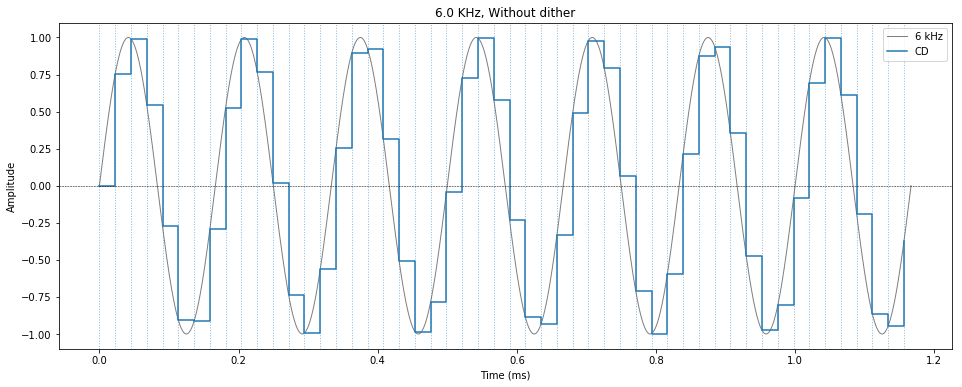

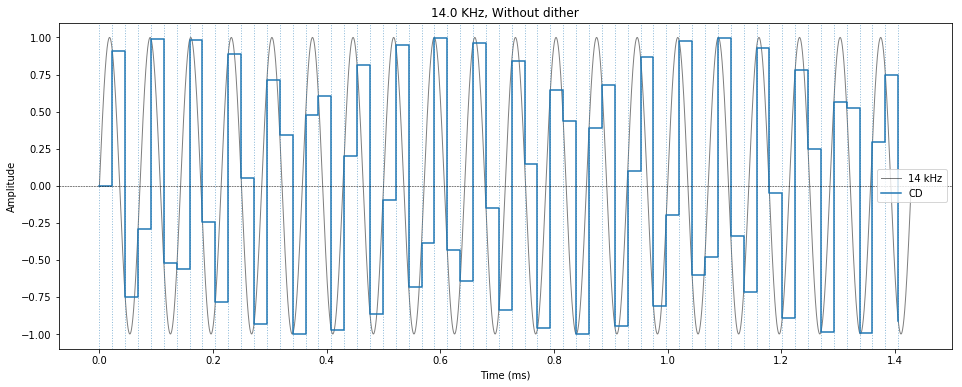

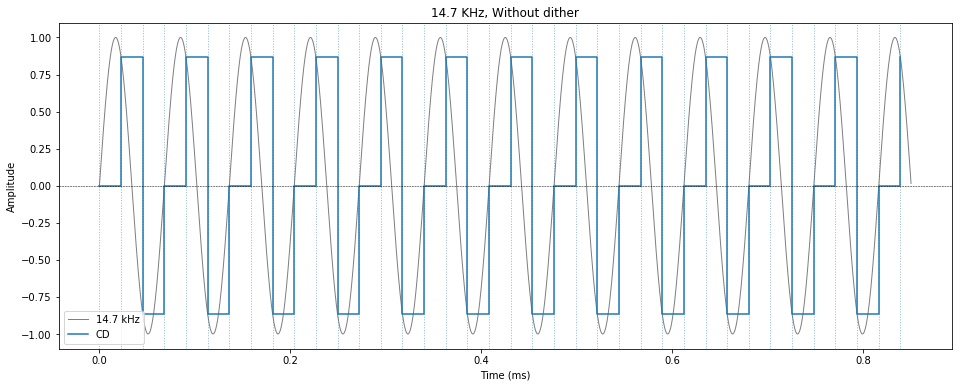

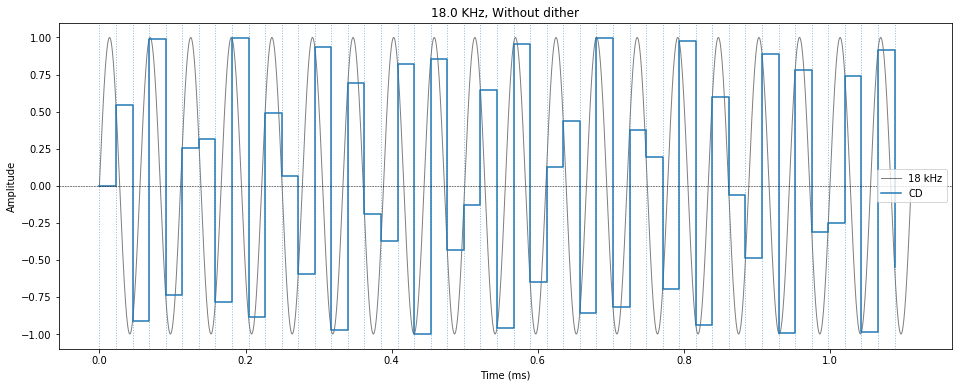

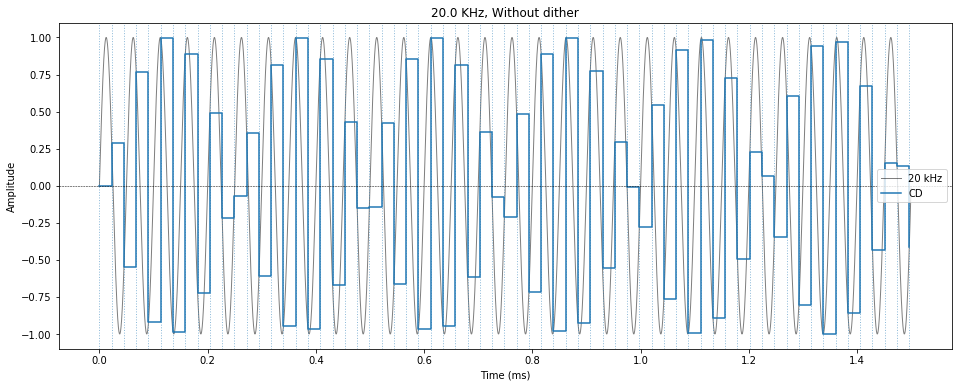

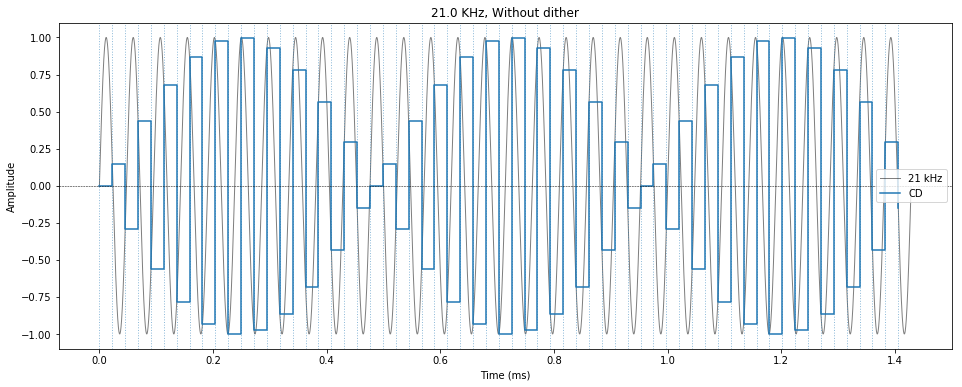

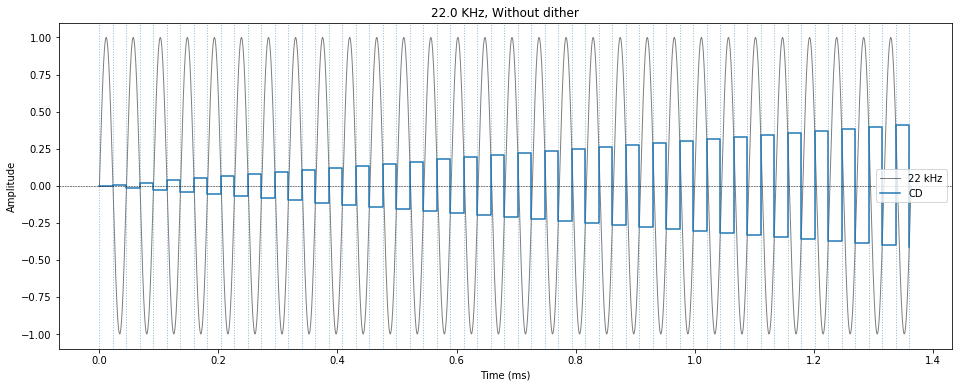

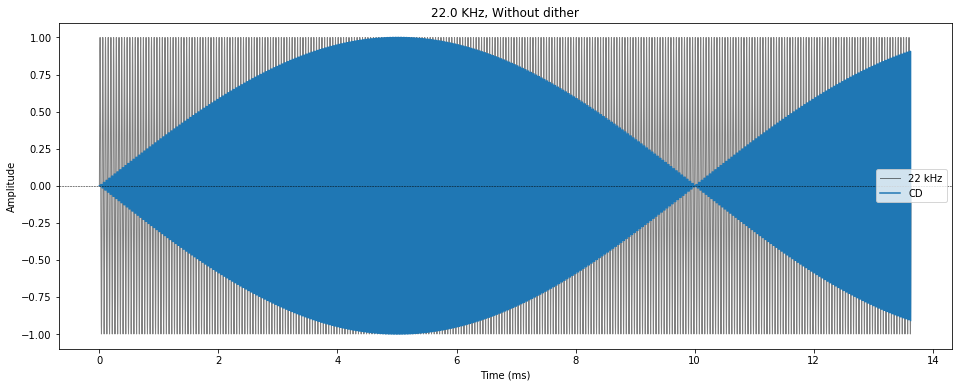

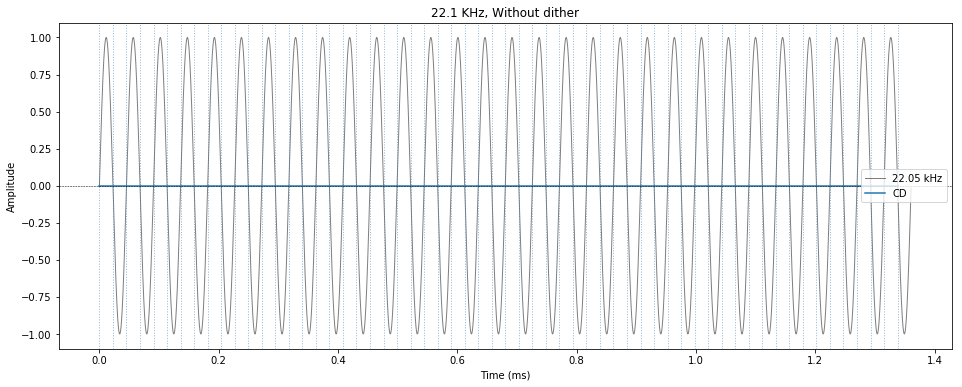

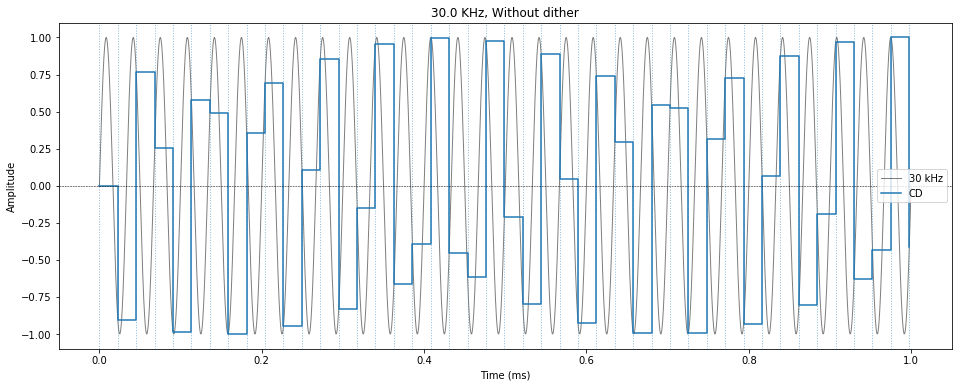

In [5]:
digi_signal = {}
noise_signal = dict([(k, {}) for k in dither_setup.keys()])
plots_shown = 'zga' # a for audio, n for noise, g for grids, z for zero line

for wavetype, wlabel, f, n_waves in experiments:
    audio = wavetype(wlabel, f)
    freq = "%.1f KHz" % (f/1e3)
    length = n_waves * 1/f
    dith_results = []
    for dithering, setup in dither_setup.items():
        fig, ax = plt.subplots()
        digi_signal[dithering] = dict([(ADC.label, {}) for ADC in ADC_list])
        if 'a' in plots_shown:
            noise_signal[dithering]['time_domain'] = audio.plot(
                length, plt, color='k', lw=1, alpha=0.5)
        ADC_results = []
        for ADC in ADC_list:
            # sample:
            converted, sampled_time, sampled_signal, noise_signal[dithering][ADC.label] = ADC.quantize(
                audio, length, dither=setup['state']
            )
            t = sampled_time.repeat(2)[1:]
            y = sampled_signal.repeat(2)[:-1]
            ax.plot(t*1000, y, lw=1.5, color=ADC.color, label=ADC.label) # t (ms)
            
            signal_domain = audio.time_array(length)
            if 'n' in plots_shown:
                ax.plot(signal_domain*1000, noise_signal[dithering][ADC.label], lw=0.5, ls='-', 
                        color=ADC.color, label=waves.of(ADC.label) + ' noise')
            
            ADC_results.append(converted)
            digi_signal[dithering][ADC.label]['time_domain'] = sampled_time
            digi_signal[dithering][ADC.label]['signal'] = sampled_signal
            print(waves.of(ADC.label), 'stream', setup['label'].lower(), 
                  '(%i levels):' % ADC.levels, waves.shortlist(converted.stream, show=10)
                 )
        dith_results.append(ADC_results)

        if 'g' in plots_shown:
            # Show grid of ADC with the lowest sampling frequency:
            ADC = sorted(ADC_list, key=lambda ADC: ADC.sampling_frequency)[0]
            # but only if not many sampling intervals:
            if length/ADC.sampling_interval <= 100:
                [ax.axvline(t*1000, color=ADC.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, ADC.sampling_interval)]

            # Show grid of ADC with the lowest resolution:
            ADC = sorted(ADC_list, key=lambda ADC: ADC.amplitude_resolution)[0]
            # but only if no more than 4-bit, since too many levels
            if ADC.amplitude_resolution <= 4:
                [ax.axhline(A, color=ADC.color, lw=1, ls=':', alpha=0.5) for A in np.linspace(ADC.amp_min, ADC.amp_max, ADC.levels)]

        ax.legend()
        if 'z' in plots_shown:
            ax.axhline(0, lw=0.5, ls='--', color='k')
        ax.set_title(', '.join([freq, setup['label']]
        ))
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Time (ms)')
        fig.set_size_inches(16, 6)
    exp_results.append(dith_results)

In [6]:
results = [r[0][0] for r in exp_results]

D/A conversion
============

In [7]:
results[1].stream

array([32767, 53369, 59810, 47664, 25278,  8040,  7798, 24718, 47171,
       59723, 53747, 33351, 12553,  5649, 17385, 39693, 57241, 57967,
       41371, 18862,  5910, 11418, 31600, 52584, 59947, 48628, 26407,
        8557,  7348, 23611, 46167, 59512, 54475, 34517, 13356,  5537,
       16435, 38558, 56701, 58393, 42471, 19879,  6145, 10710, 30436,
       51763, 60034, 49563, 27547,  9119,  6945, 22520])

In [54]:
for digital in results:
    print(digital.sampled_time)

[0.00000000e+00 2.26757370e-05 4.53514739e-05 6.80272109e-05
 9.07029478e-05 1.13378685e-04 1.36054422e-04 1.58730159e-04
 1.81405896e-04 2.04081633e-04 2.26757370e-04 2.49433107e-04
 2.72108844e-04 2.94784580e-04 3.17460317e-04 3.40136054e-04
 3.62811791e-04 3.85487528e-04 4.08163265e-04 4.30839002e-04
 4.53514739e-04 4.76190476e-04 4.98866213e-04 5.21541950e-04
 5.44217687e-04 5.66893424e-04 5.89569161e-04 6.12244898e-04
 6.34920635e-04 6.57596372e-04 6.80272109e-04 7.02947846e-04
 7.25623583e-04 7.48299320e-04 7.70975057e-04 7.93650794e-04
 8.16326531e-04 8.39002268e-04 8.61678005e-04 8.84353741e-04
 9.07029478e-04 9.29705215e-04 9.52380952e-04 9.75056689e-04
 9.97732426e-04 1.02040816e-03 1.04308390e-03 1.06575964e-03
 1.08843537e-03 1.11111111e-03 1.13378685e-03 1.15646259e-03
 1.17913832e-03 1.20181406e-03 1.22448980e-03 1.24716553e-03
 1.26984127e-03 1.29251701e-03 1.31519274e-03 1.33786848e-03
 1.36054422e-03 1.38321995e-03 1.40589569e-03 1.42857143e-03
 1.45124717e-03 1.473922

The noise is more decorrelated from the signal when dither is added. However, this comes at the cost of increased noise power:

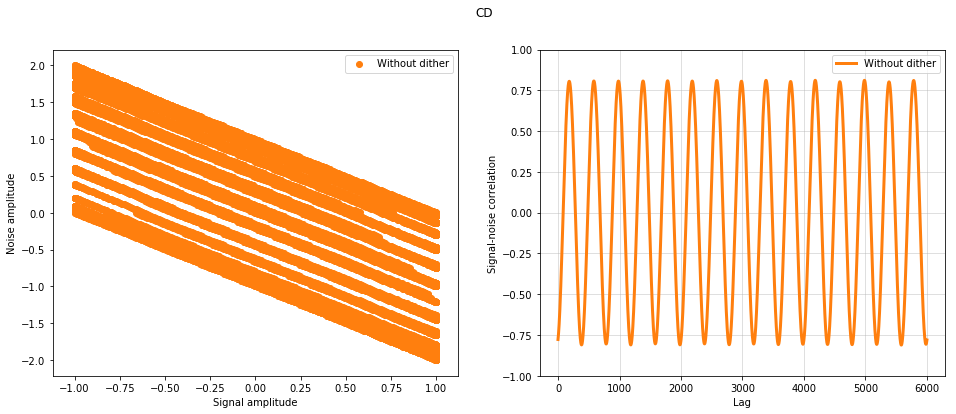

In [6]:
def show_noise_signal_correlation(signal, dither_setup, noises, ADC):
    fig, ax = plt.subplots(1, 2)
    for dithering, setup in dither_setup.items():
        analog = signal.function(noises[dithering]['time_domain'])
        ax[0].scatter(analog, noises[dithering][ADC.label], color=setup['c'], label=setup['label'])
        ax[1].plot(*waves.twopar_correlation(analog, noises[dithering][ADC.label]), color=setup['c'], lw=setup['w'], label=setup['label'])
    ax[0].legend()
    ax[0].set_xlabel('Signal amplitude')
    ax[0].set_ylabel('Noise amplitude')
    ax[1].set_ylim(-1, 1)
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Signal-noise correlation')
    ax[1].legend()
    fig.suptitle(ADC.label)
    fig.set_size_inches(16, 6)

for ADC in ADC_list:
    show_noise_signal_correlation(audio, dither_setup, noise_signal, ADC)

PCM 2 is unaffected, probably because of the high resolution, but for PCM 1 we can see that the correlation is reduced although the noise amplitude has enhanced.

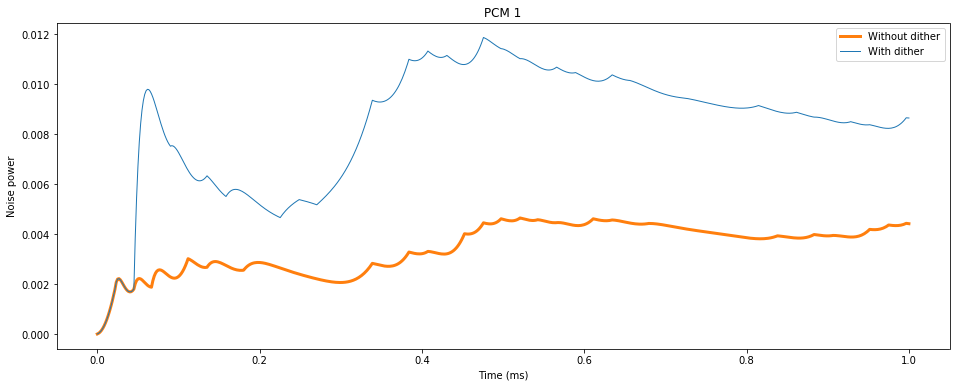

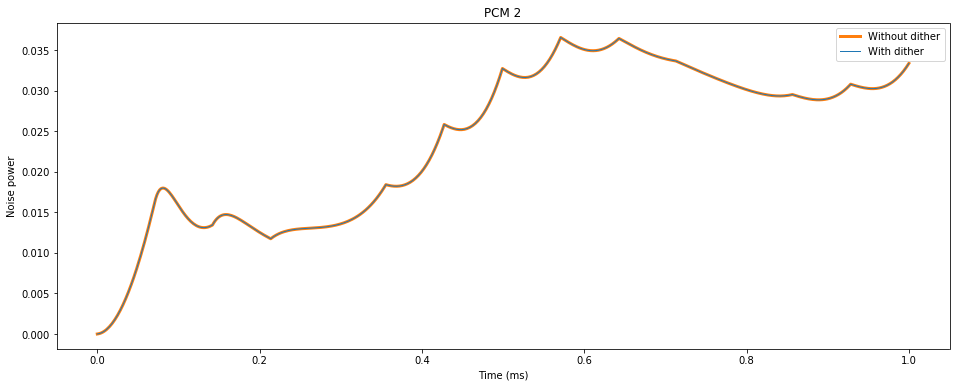

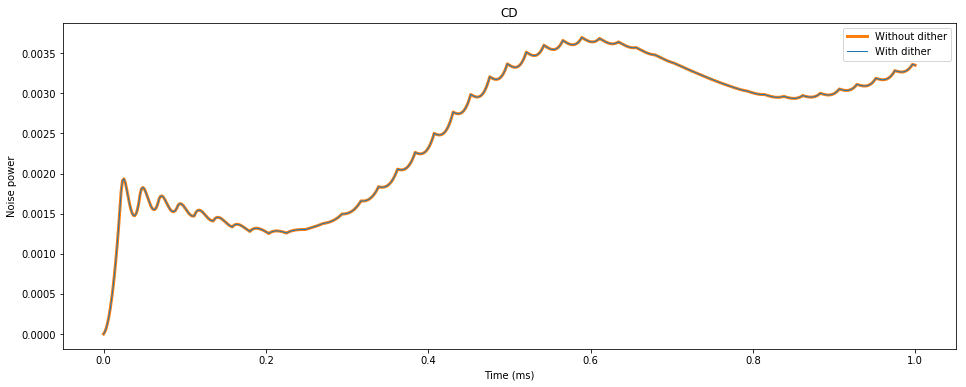

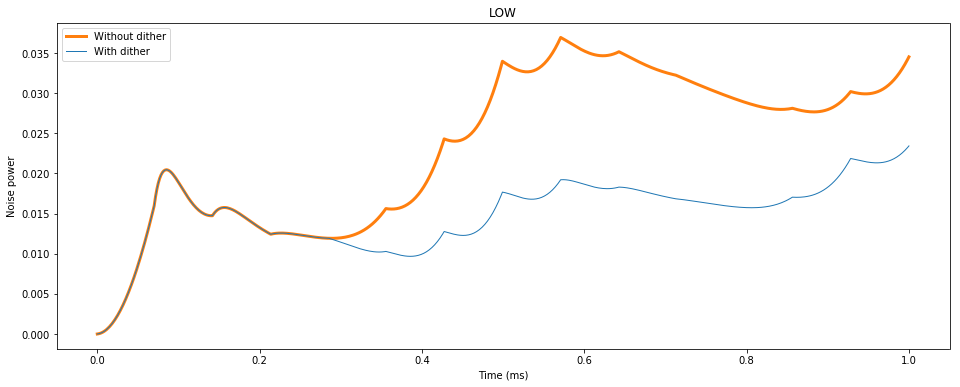

In [17]:
for ADC in ADC_list:
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        ax.plot(noise_signal[dithering]['time_domain']*1000, 
                [st.moment(noise_signal[dithering][ADC.label][:t+1], moment=2) for t in range(len(noise_signal[dithering]['time_domain']))], 
                color=setup['c'], lw=setup['w'], label=setup['label'])
        ax.set_title(ADC.label)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Noise power')
        ax.legend()
        fig.set_size_inches(16, 6)

Here we can also see, for PCM 1, that the introduction of dither enhanced the total noise power.
Let us also have a look at the Fourier transform of the signals.

In [18]:
from scipy.fftpack import fft, fftfreq, fftshift

def fourier(dither_setup, digi_signal, ADC):
    style = iter([('C1', 3), ('C0', 1)])
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        t = digi_signal[dithering][ADC.label]['time_domain']
        yf = fft(digi_signal[dithering][ADC.label]['signal'])
        tf = fftfreq(t.size, d=ADC.sampling_interval)
        tf, yf = fftshift(tf), fftshift(yf)
        c, w = next(style)
        ax.vlines(tf/1000, 0, np.abs(yf)*2/t.size, color=setup['c'], lw=setup['w'], label=setup['label'])
    ax.legend()
    #ax.set_xscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(ADC.label)
    ax.grid(which='both', alpha=0.5)
    fig.set_size_inches(16, 6)

In [31]:
#for ADC in ADC_list:
#    fourier(dither_setup, digi_signal, ADC)